In [3]:
!pip install prophet plotly

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   - -------------------------------------- 0.5/13.3 MB 5.6 MB/s eta 0:00:03
   ----- ---------------------------------- 1.8/13.3 MB 5.9 MB/s eta 0:00:02
   --------- ------------------------------ 3.1/13.3 MB 6.1 MB/s eta 0:00:02
   ------------- -------------------------- 4.5/13.3 MB 6.1 MB/s eta 0:00:02
   ------------------ --------------------- 6.0/13.3 MB 6.3 MB/s eta 0:00:02
   ---------------------- ----------------- 7.3/13.3 MB 6.4 MB/s eta 0:00:01
   -------------------------- ------------- 8.9/13.3 MB 6.4 MB/s eta 0:00:01
   ------------------------------ --------- 10.2/13.3 MB 6.5 MB/s eta 0:00:01
   ----------------------------------- ---- 11.8/13.3 MB 6.5 MB/s eta 0:00:01
   ---------------------------------------  13.1/13.3 MB 6.5 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 6.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   -------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Optional: Set a nice plot style
plt.style.use('fivethirtyeight')
sns.set_context("talk")

### Load the Data: Load the CSV file using pandas.

In [180]:
aqi = pd.read_csv('delhi_aqi.csv')

aqi.head(1)

,date,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2020-11-25 01:00:00,2616.88,2.18,70.6,13.59,38.62,364.61,411.73,28.63


In [6]:
aqi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18776 entries, 0 to 18775
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    18776 non-null  object 
 1   co      18776 non-null  float64
 2   no      18776 non-null  float64
 3   no2     18776 non-null  float64
 4   o3      18776 non-null  float64
 5   so2     18776 non-null  float64
 6   pm2_5   18776 non-null  float64
 7   pm10    18776 non-null  float64
 8   nh3     18776 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


#### The date column is of object(string) type. We need to convert it into a proper datetime format.

In [11]:
# Convert the 'date' column to a proper datetime format
aqi['date'] = pd.to_datetime(aqi['date'])
aqi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18776 entries, 0 to 18775
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    18776 non-null  datetime64[ns]
 1   co      18776 non-null  float64       
 2   no      18776 non-null  float64       
 3   no2     18776 non-null  float64       
 4   o3      18776 non-null  float64       
 5   so2     18776 non-null  float64       
 6   pm2_5   18776 non-null  float64       
 7   pm10    18776 non-null  float64       
 8   nh3     18776 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 1.3 MB


In [131]:
# --- FINAL Corrected Data Preparation: Forecasting PM2.5 Directly ---

# 1. Load the dataset
df = pd.read_csv('delhi_aqi.csv')

# 2. Convert 'date' to datetime and set it as the index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 3. Resample the hourly data to get daily averages
daily_df = df.resample('D').mean()

# 4. Reset index to get 'date' back as a column
daily_df.reset_index(inplace=True)

# 5. Prepare the DataFrame for Prophet by selecting PM2.5 as the target
prophet_df = daily_df[['date', 'pm2_5']].copy()
prophet_df.rename(columns={'date': 'ds', 'pm2_5': 'y'}, inplace=True)

# Drop any days where the average could not be calculated
prophet_df.dropna(inplace=True)

# We will now use this as our main DataFrame
aqi_df = prophet_df

print("Corrected Daily PM2.5 DataFrame for Forecasting:")
print(aqi_df.head())
print("\nDataFrame Info:")
aqi_df.info()

Corrected Daily PM2.5 DataFrame for Forecasting:
          ds           y
0 2020-11-25  342.301739
1 2020-11-26  180.754167
2 2020-11-27  115.901667
3 2020-11-28  197.889167
4 2020-11-29  329.381667

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 789 entries, 0 to 790
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      789 non-null    datetime64[ns]
 1   y       789 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 18.5 KB


In [133]:
daily_df.head()

,date,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2020-11-25,2971.566087,14.880000,93.549130,26.791304,82.430870,342.301739,405.037826,26.720435
1,2020-11-26,2314.806667,24.443750,65.418750,20.753333,65.158333,180.754167,226.001250,21.993750
2,2020-11-27,1592.159583,4.934167,56.221667,43.925000,41.485000,115.901667,143.952500,20.280000
3,2020-11-28,2461.115833,11.879583,70.046667,50.372500,41.515417,197.889167,234.861250,23.145000
4,2020-11-29,4516.680417,65.719583,93.949583,34.696250,77.785417,329.381667,404.049583,47.233750


#### Prophet has a strict requirement: the date column must be named ds and the target value column must be named y

### Step 4: Train/Test Split & Model Training.
##### We'll train the model on the majority of the data and hold out the last portion to test its predictions against real, unseen data.



### 1. Split the data into a training set and a test set

In [138]:
# For time series forecasting, it's crucial that the test set comes chronologically after the training set. 
# We'll use data up to mid-2024 for training and the rest for testing.

split_date = '2022-11-01'
train_df = aqi_df[aqi_df['ds'] <= split_date].copy()
test_df = aqi_df[aqi_df['ds'] > split_date].copy()

print(f"Training data points: {len(train_df)}")
print(f"Test data points: {len(test_df)}")

Training data points: 706
Test data points: 83


In [140]:
train_df.head()

,ds,y
0,2020-11-25,342.301739
1,2020-11-26,180.754167
2,2020-11-27,115.901667
3,2020-11-28,197.889167
4,2020-11-29,329.381667


In [142]:
train_df.tail(1)

,ds,y
706,2022-11-01,248.253333


In [144]:
test_df.head()

,ds,y
707,2022-11-02,316.106667
708,2022-11-03,362.997500
709,2022-11-04,557.125000
710,2022-11-05,322.296250
711,2022-11-06,414.982917


### --- 2. Defining Indian Holidays (Corrected Dates) ---


In [147]:
# Create a DataFrame for important Indian holidays within the dataset's range.
diwali = pd.DataFrame({
  'holiday': 'Diwali',
  'ds': pd.to_datetime(['2020-11-14', '2021-11-04', '2022-10-24']),
  'lower_window': -2, # Model effects from 2 days before
  'upper_window': 3,  # Model effects up to 3 days after
})

holi = pd.DataFrame({
  'holiday': 'Holi',
  'ds': pd.to_datetime(['2021-03-29', '2022-03-18']),
  'lower_window': -1,
  'upper_window': 1,
})

holidays_df = pd.concat((diwali, holi))

In [149]:
holidays_df

,holiday,ds,lower_window,upper_window
0,Diwali,2020-11-14,-2,3
1,Diwali,2021-11-04,-2,3
2,Diwali,2022-10-24,-2,3
0,Holi,2021-03-29,-1,1
1,Holi,2022-03-18,-1,1


### --- 3. Train the Prophet Model ---

In [152]:
# Initialize the Prophet model, passing in our holidays
model = Prophet(holidays=holidays_df, yearly_seasonality=True)

# Fit the model to the training data
model.fit(train_df)

print("\nModel training complete!")

09:52:27 - cmdstanpy - INFO - Chain [1] start processing
09:52:31 - cmdstanpy - INFO - Chain [1] done processing



Model training complete!


## Step 5: Evaluate the Model on the Test Set

In [155]:
# Create a dataframe with the dates from the test set for prediction
future_test_df = test_df[['ds']]  # using [[]] converts series to dataframe

# Use the trained model to make predictions on these future dates
forecast_test = model.predict(future_test_df)
forecast_test.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Diwali,Diwali_lower,Diwali_upper,Holi,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-11-02,227.351954,210.578010,546.230393,227.351954,227.351954,0.0,0.0,0.0,0.0,...,23.504353,23.504353,23.504353,136.718517,136.718517,136.718517,0.0,0.0,0.0,387.574823
1,2022-11-03,227.341008,230.996226,572.636908,227.341008,227.341008,0.0,0.0,0.0,0.0,...,25.918201,25.918201,25.918201,144.875889,144.875889,144.875889,0.0,0.0,0.0,398.135098
2,2022-11-04,227.330063,213.254204,561.947911,227.330063,227.330063,0.0,0.0,0.0,0.0,...,-4.987140,-4.987140,-4.987140,152.673612,152.673612,152.673612,0.0,0.0,0.0,375.016535
3,2022-11-05,227.319118,185.223604,518.741950,227.319118,227.319118,0.0,0.0,0.0,0.0,...,-37.814649,-37.814649,-37.814649,160.062929,160.062929,160.062929,0.0,0.0,0.0,349.567398
4,2022-11-06,227.308173,199.576633,537.397063,227.308173,227.308173,0.0,0.0,0.0,0.0,...,-32.474737,-32.474737,-32.474737,166.999940,166.999940,166.999940,0.0,0.0,0.0,361.833375


In [157]:
print("Predictions for the test period generated.")
print(forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

Predictions for the test period generated.
          ds        yhat  yhat_lower  yhat_upper
0 2022-11-02  387.574823  210.578010  546.230393
1 2022-11-03  398.135098  230.996226  572.636908
2 2022-11-04  375.016535  213.254204  561.947911
3 2022-11-05  349.567398  185.223604  518.741950
4 2022-11-06  361.833375  199.576633  537.397063


In [159]:
future_test_df.head()

,ds
707,2022-11-02
708,2022-11-03
709,2022-11-04
710,2022-11-05
711,2022-11-06


In [176]:
future_test_df.tail(1)

,ds
790,2023-01-24


In [161]:
# Merge the actual values from the test set with our forecasted values
results_df = pd.merge(test_df, forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

# Calculate key error metrics
mae = mean_absolute_error(results_df['y'], results_df['yhat'])
rmse = np.sqrt(mean_squared_error(results_df['y'], results_df['yhat']))

print(f"Mean Absolute Error (MAE) on Test Set: {mae:.2f}")
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse:.2f}")

Mean Absolute Error (MAE) on Test Set: 129.75
Root Mean Squared Error (RMSE) on Test Set: 164.39


## Step 6: Create and Visualize the Final Forecast

#### 1. Generate the Future Forecast

In [164]:
# Create a dataframe for 365 days into the future
future_df = model.make_future_dataframe(periods=365)

# Generate the forecast
forecast = model.predict(future_df)

print("Forecast for the next 365 days:")
# Show the last few rows which contain the future predictions
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

Forecast for the next 365 days:
             ds        yhat  yhat_lower  yhat_upper
1066 2023-10-28  275.850317  117.891455  433.171400
1067 2023-10-29  290.270721  132.796092  454.167562
1068 2023-10-30  342.782613  179.482754  518.016762
1069 2023-10-31  355.564325  189.513459  515.934292
1070 2023-11-01  372.969816  193.143952  549.175753


#### 2. Visualize the Forecast and Components

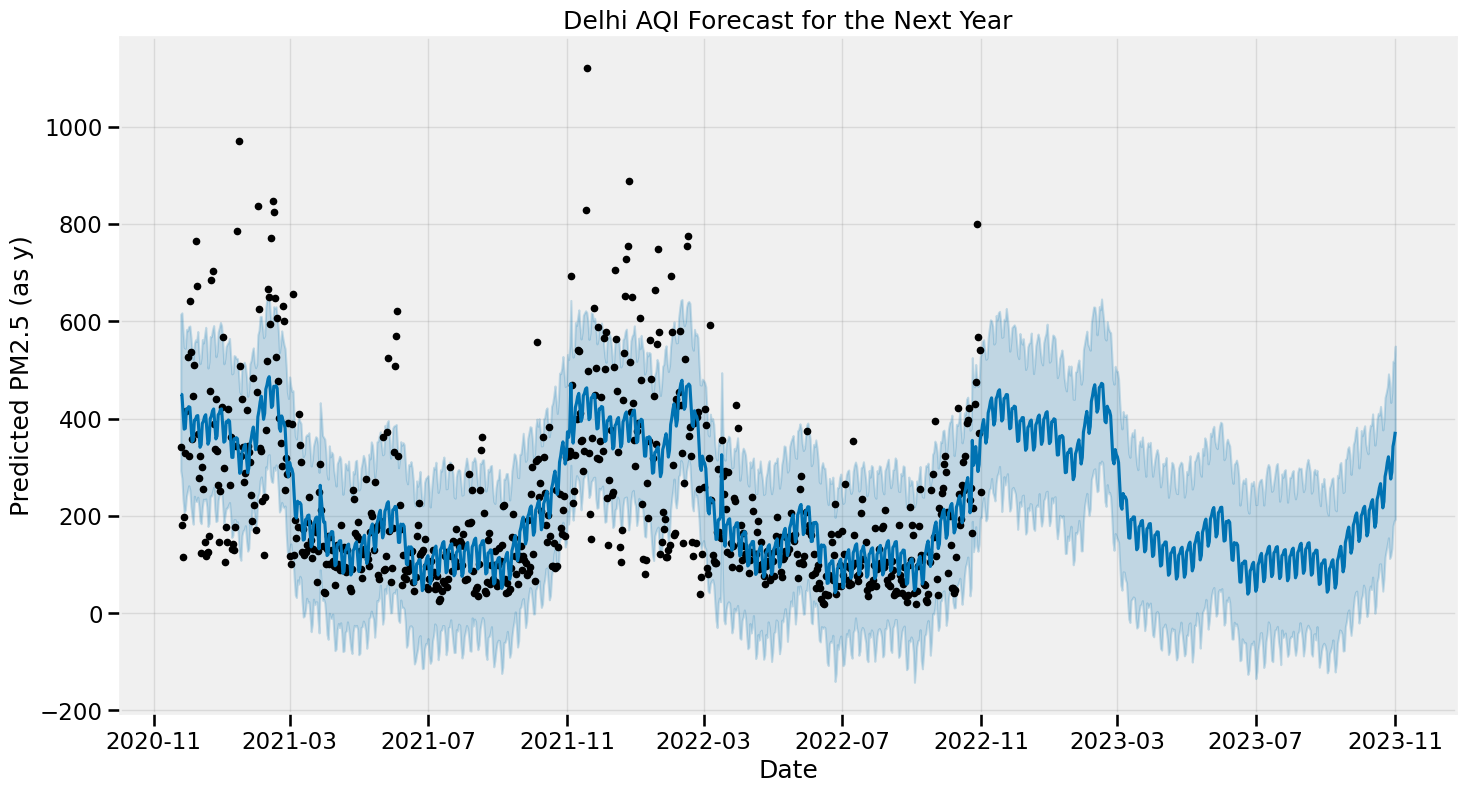

In [168]:
# Plot the complete forecast, including historical data and future predictions
fig1 = model.plot(forecast, figsize=(15, 8))
plt.title('Delhi AQI Forecast for the Next Year')
plt.xlabel('Date')
plt.ylabel('Predicted PM2.5 (as y)')
plt.show()

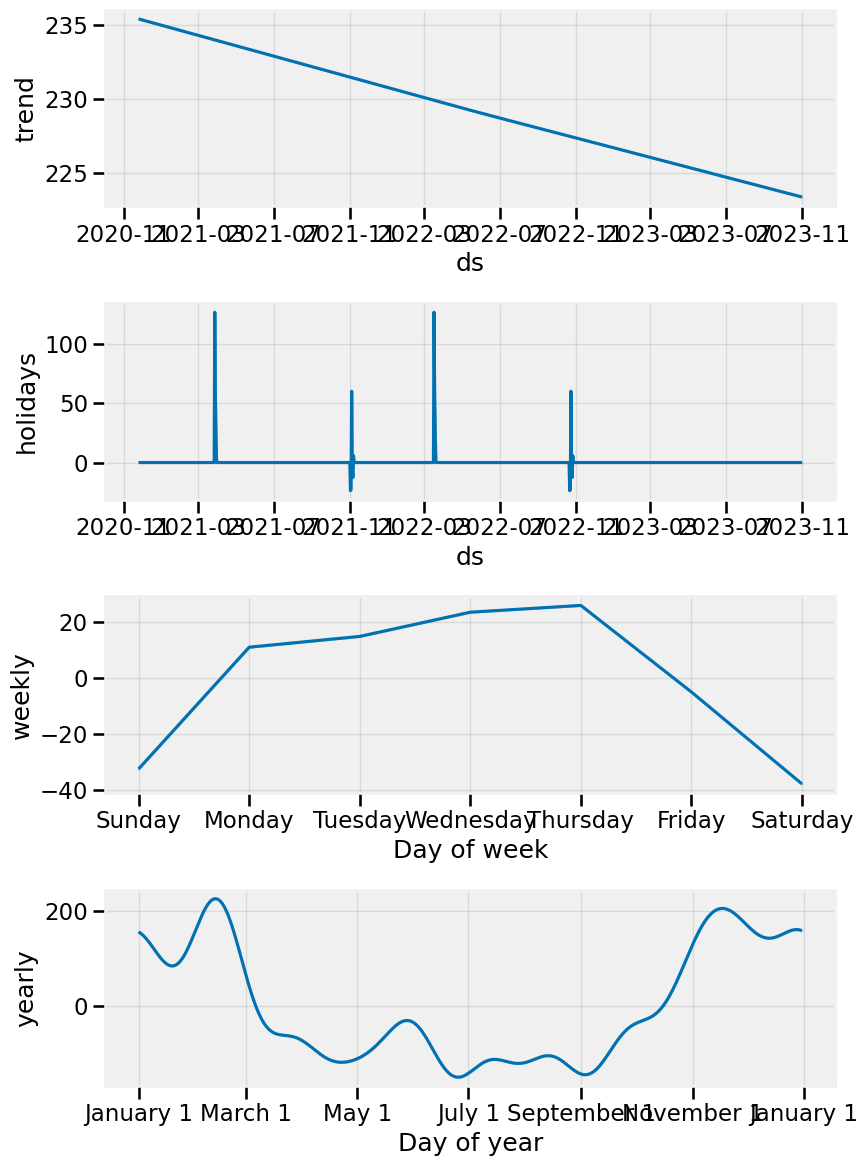

In [170]:
# Plot the individual components of the forecast: Trend, Holidays, Weekly, and Yearly seasonality
fig2 = model.plot_components(forecast)
plt.show()